Training PPO agent...
Episode 0, Average Reward: -20214.70


/var/folders/tt/3h_jlt8571z664b95jr80v_40000gn/T/ipykernel_60245/49040932.py:316: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  states = torch.FloatTensor(agent['states'])


Episode 100, Average Reward: -19544.25
Episode 200, Average Reward: -18582.41
Episode 300, Average Reward: -17567.45
Episode 400, Average Reward: -16804.71
Episode 500, Average Reward: -16302.45
Episode 600, Average Reward: -16013.57
Episode 700, Average Reward: -15649.62
Episode 800, Average Reward: -15446.96
Episode 900, Average Reward: -15478.86


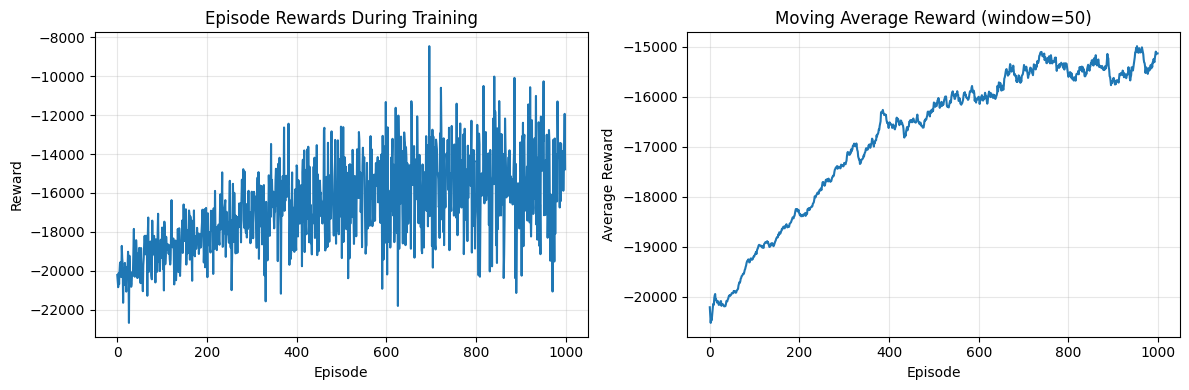


Evaluating trained agent...
Cumulative Profit - Mean: -14964.81, Std: 2266.30, Max: -9471.60, Min: -20779.90


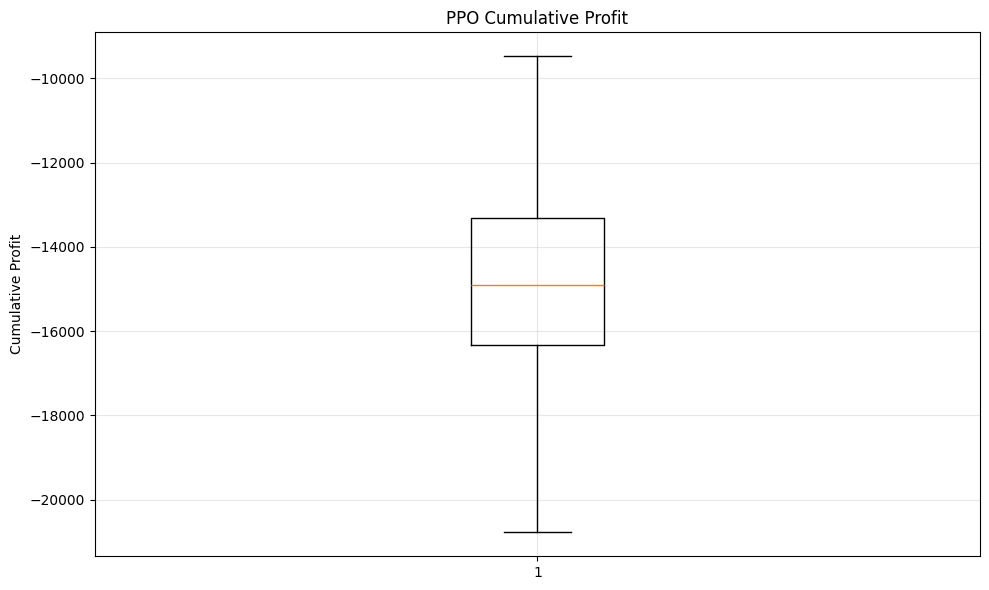

In [1]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import random
import collections
from itertools import chain

# Set random seeds for reproducibility
seed = 2021
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# State functions
def create_state(product_types_num, distr_warehouses_num, T, demand_history, t=0):
    """Create state representation for supply chain environment"""
    return {
        'product_types_num': product_types_num,
        'factory_stocks': np.zeros((product_types_num,), dtype=np.int32),
        'distr_warehouses_num': distr_warehouses_num,
        'distr_warehouses_stocks': np.zeros((distr_warehouses_num, product_types_num), dtype=np.int32),
        'T': T,
        'demand_history': demand_history,
        't': t
    }

def state_to_array(state):
    """Convert state to array representation"""
    return np.concatenate((
        state['factory_stocks'],
        state['distr_warehouses_stocks'].flatten(),
        np.hstack(list(chain(*chain(*state['demand_history'])))),
        [state['t']]))

def get_stock_levels(state):
    """Get stock levels from state"""
    return np.concatenate((
        state['factory_stocks'],
        state['distr_warehouses_stocks'].flatten()))

# Action functions
def create_action(product_types_num, distr_warehouses_num):
    """Create action representation for supply chain environment"""
    return {
        'production_level': np.zeros((product_types_num,), dtype=np.int32),
        'shipped_stocks': np.zeros((distr_warehouses_num, product_types_num), dtype=np.int32)
    }

# Supply Chain Environment functions
def create_supply_chain_env():
    """Create supply chain environment"""
    env = {
        'product_types_num': 2,
        'distr_warehouses_num': 2,
        'T': 25,
        'd_max': np.array([3, 6], np.int32),
        'd_var': np.array([2, 1], np.int32),
        'sale_prices': np.array([20, 10], np.int32),
        'production_costs': np.array([2, 1], np.int32),
        'storage_capacities': np.array([[3, 4], [6, 8], [9, 12]], np.int32),
        'storage_costs': np.array([[6, 3], [4, 2], [2, 1]], np.float32),
        'transportation_costs': np.array([[.1, .3], [.2, .6]], np.float32),
        't': 0
    }
    env['penalty_costs'] = .5 * env['sale_prices']
    return env

def reset_supply_chain_env(env, demand_history_len=5):
    """Reset supply chain environment"""
    env['demand_history'] = collections.deque(maxlen=demand_history_len)
    for d in range(demand_history_len):
        env['demand_history'].append(np.zeros(
            (env['distr_warehouses_num'], env['product_types_num']), dtype=np.int32))
    env['t'] = 0

def calculate_demand(env, j, i, t):
    """Calculate demand for warehouse j, product i at time t"""
    demand = np.round(
        env['d_max'][i-1]/2 +
        env['d_max'][i-1]/2*np.cos(4*np.pi*(2*j*i+t)/env['T']) +
        np.random.randint(0, env['d_var'][i-1]+1))
    return demand

def get_initial_state(env):
    """Get initial state of supply chain environment"""
    return create_state(env['product_types_num'], env['distr_warehouses_num'],
                       env['T'], list(env['demand_history']))

def step_supply_chain_env(env, state, action):
    """Step supply chain environment"""
    demands = np.fromfunction(
        lambda j, i: calculate_demand(env, j+1, i+1, env['t']),
        (env['distr_warehouses_num'], env['product_types_num']),
        dtype=np.int32)

    next_state = create_state(env['product_types_num'], env['distr_warehouses_num'],
                             env['T'], list(env['demand_history']))

    next_state['factory_stocks'] = np.minimum(
        np.subtract(np.add(state['factory_stocks'], action['production_level']),
                   np.sum(action['shipped_stocks'], axis=0)),
        env['storage_capacities'][0])

    for j in range(env['distr_warehouses_num']):
        next_state['distr_warehouses_stocks'][j] = np.minimum(
            np.subtract(np.add(state['distr_warehouses_stocks'][j],
                              action['shipped_stocks'][j]), demands[j]),
            env['storage_capacities'][j+1])

    # Calculate reward
    total_revenues = np.dot(env['sale_prices'], np.sum(demands, axis=0))
    total_production_costs = np.dot(env['production_costs'], action['production_level'])
    total_transportation_costs = np.dot(
        env['transportation_costs'].flatten(), action['shipped_stocks'].flatten())
    total_storage_costs = np.dot(
        env['storage_costs'].flatten(),
        np.maximum(get_stock_levels(next_state),
                  np.zeros(((env['distr_warehouses_num']+1) * env['product_types_num']),
                          dtype=np.int32)))
    total_penalty_costs = -np.dot(
        env['penalty_costs'],
        np.add(np.sum(np.minimum(next_state['distr_warehouses_stocks'],
                               np.zeros((env['distr_warehouses_num'], env['product_types_num']),
                                       dtype=np.int32)), axis=0),
              np.minimum(next_state['factory_stocks'],
                       np.zeros((env['product_types_num'],), dtype=np.int32))))

    reward = (total_revenues - total_production_costs - 
             total_transportation_costs - total_storage_costs - total_penalty_costs)

    env['demand_history'].append(demands)
    env['t'] += 1

    return next_state, reward, env['t'] == env['T']-1

# Gym environment wrapper functions
def create_gym_env():
    """Create gym environment wrapper"""
    gym_env = {}
    reset_gym_env(gym_env)
    
    supply_chain = gym_env['supply_chain']
    
    # Action space bounds
    low_act = np.zeros(
        ((supply_chain['distr_warehouses_num']+1) * supply_chain['product_types_num']),
        dtype=np.int32)
    high_act = np.zeros(
        ((supply_chain['distr_warehouses_num']+1) * supply_chain['product_types_num']),
        dtype=np.int32)
    high_act[:supply_chain['product_types_num']] = np.sum(
        supply_chain['storage_capacities'], axis=0)
    high_act[supply_chain['product_types_num']:] = (
        supply_chain['storage_capacities'].flatten()[supply_chain['product_types_num']:])
    
    gym_env['action_space'] = {'low': low_act, 'high': high_act}
    
    # Observation space bounds
    initial_state = get_initial_state(supply_chain)
    obs_len = len(state_to_array(initial_state))
    
    low_obs = np.zeros((obs_len,), dtype=np.int32)
    low_obs[:supply_chain['product_types_num']] = (
        -np.sum(supply_chain['storage_capacities'][1:], axis=0) * supply_chain['T'])
    low_obs[supply_chain['product_types_num']:
           (supply_chain['distr_warehouses_num']+1) * supply_chain['product_types_num']] = (
        np.array([-(supply_chain['d_max']+supply_chain['d_var']) * supply_chain['T']] * 
                supply_chain['distr_warehouses_num']).flatten())
    
    high_obs = np.zeros((obs_len,), dtype=np.int32)
    high_obs[:(supply_chain['distr_warehouses_num']+1) * supply_chain['product_types_num']] = (
        supply_chain['storage_capacities'].flatten())
    high_obs[(supply_chain['distr_warehouses_num']+1) * supply_chain['product_types_num']:
            len(high_obs)-1] = np.array([
        supply_chain['d_max']+supply_chain['d_var']] * 
        len(list(chain(*supply_chain['demand_history'])))).flatten()
    high_obs[len(high_obs)-1] = supply_chain['T']
    
    gym_env['observation_space'] = {'low': low_obs, 'high': high_obs}
    
    return gym_env

def reset_gym_env(gym_env):
    """Reset gym environment"""
    gym_env['supply_chain'] = create_supply_chain_env()
    reset_supply_chain_env(gym_env['supply_chain'])
    gym_env['state'] = get_initial_state(gym_env['supply_chain'])
    return state_to_array(gym_env['state'])

def step_gym_env(gym_env, action):
    """Step gym environment"""
    supply_chain = gym_env['supply_chain']
    
    action_obj = create_action(supply_chain['product_types_num'], 
                              supply_chain['distr_warehouses_num'])
    action_obj['production_level'] = action[:supply_chain['product_types_num']].astype(np.int32)
    action_obj['shipped_stocks'] = action[supply_chain['product_types_num']:].reshape(
        (supply_chain['distr_warehouses_num'], supply_chain['product_types_num'])).astype(np.int32)

    gym_env['state'], reward, done = step_supply_chain_env(supply_chain, gym_env['state'], action_obj)
    return state_to_array(gym_env['state']), reward, done, {}

# PPO Network functions
def create_ppo_network(state_size, action_size, hidden_size=128):
    """Create PPO neural network"""
    network = nn.Sequential(
        nn.Linear(state_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU()
    )
    
    actor_mean = nn.Linear(hidden_size, action_size)
    actor_std = nn.Linear(hidden_size, action_size)
    critic = nn.Linear(hidden_size, 1)
    
    return {
        'shared': network,
        'actor_mean': actor_mean,
        'actor_std': actor_std,
        'critic': critic
    }

def forward_ppo_network(network, state):
    """Forward pass through PPO network"""
    shared_features = network['shared'](state)
    
    action_mean = network['actor_mean'](shared_features)
    action_std = F.softplus(network['actor_std'](shared_features)) + 1e-5
    value = network['critic'](shared_features)
    
    return action_mean, action_std, value

def get_action_and_value(network, state):
    """Get action and value from network"""
    action_mean, action_std, value = forward_ppo_network(network, state)
    dist = Normal(action_mean, action_std)
    action = dist.sample()
    log_prob = dist.log_prob(action).sum(dim=-1)
    return action, log_prob, value

# PPO Agent functions
def create_ppo_agent(state_size, action_size, lr=3e-4, gamma=0.99, eps_clip=0.2, k_epochs=4):
    """Create PPO agent"""
    network = create_ppo_network(state_size, action_size)
    
    # Get all parameters from the network components
    params = list(network['shared'].parameters()) + \
             list(network['actor_mean'].parameters()) + \
             list(network['actor_std'].parameters()) + \
             list(network['critic'].parameters())
    
    optimizer = optim.Adam(params, lr=lr)
    
    return {
        'gamma': gamma,
        'eps_clip': eps_clip,
        'k_epochs': k_epochs,
        'network': network,
        'optimizer': optimizer,
        'states': [],
        'actions': [],
        'log_probs': [],
        'rewards': [],
        'values': [],
        'dones': []
    }

def get_action(agent, state):
    """Get action from agent"""
    state = torch.FloatTensor(state).unsqueeze(0)
    action, log_prob, value = get_action_and_value(agent['network'], state)
    return action.squeeze().detach().numpy(), log_prob.item(), value.item()

def store_transition(agent, state, action, log_prob, reward, value, done):
    """Store transition in agent buffer"""
    agent['states'].append(state)
    agent['actions'].append(action)
    agent['log_probs'].append(log_prob)
    agent['rewards'].append(reward)
    agent['values'].append(value)
    agent['dones'].append(done)

def calculate_returns_and_advantages(agent):
    """Calculate returns and advantages"""
    returns = []
    advantages = []
    
    # Calculate returns (discounted rewards)
    R = 0
    for i in reversed(range(len(agent['rewards']))):
        R = agent['rewards'][i] + agent['gamma'] * R * (1 - agent['dones'][i])
        returns.insert(0, R)
    
    returns = torch.FloatTensor(returns)
    values = torch.FloatTensor(agent['values'])
    
    # Calculate advantages
    advantages = returns - values
    
    return returns, advantages

def update_agent(agent):
    """Update PPO agent"""
    if len(agent['states']) == 0:
        return 0
        
    # Convert lists to tensors
    states = torch.FloatTensor(agent['states'])
    actions = torch.FloatTensor(agent['actions'])
    old_log_probs = torch.FloatTensor(agent['log_probs'])
    
    # Calculate returns and advantages
    returns, advantages = calculate_returns_and_advantages(agent)
    
    # Normalize advantages
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
    
    total_loss = 0
    
    # PPO update for k epochs
    for _ in range(agent['k_epochs']):
        # Get current policy outputs
        action_means, action_stds, values = forward_ppo_network(agent['network'], states)
        dist = Normal(action_means, action_stds)
        new_log_probs = dist.log_prob(actions).sum(dim=-1)
        
        # Calculate probability ratio
        ratio = torch.exp(new_log_probs - old_log_probs)
        
        # Calculate surrogate losses
        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1 - agent['eps_clip'], 1 + agent['eps_clip']) * advantages
        
        # Actor loss (negative because we want to maximize)
        actor_loss = -torch.min(surr1, surr2).mean()
        
        # Critic loss
        critic_loss = F.mse_loss(values.squeeze(), returns)
        
        # Total loss
        loss = actor_loss + 0.5 * critic_loss
        
        # Optimization step
        agent['optimizer'].zero_grad()
        loss.backward()
        agent['optimizer'].step()
        
        total_loss += loss.item()
    
    # Clear trajectory buffer
    clear_agent_buffer(agent)
    
    return total_loss / agent['k_epochs']

def clear_agent_buffer(agent):
    """Clear agent buffer"""
    agent['states'] = []
    agent['actions'] = []
    agent['log_probs'] = []
    agent['rewards'] = []
    agent['values'] = []
    agent['dones'] = []

def train_ppo(env, episodes=1000, max_steps=25, update_freq=20):
    """Train PPO agent on the supply chain environment"""
    state_size = len(reset_gym_env(env))
    action_size = len(env['action_space']['low'])
    
    agent = create_ppo_agent(state_size, action_size)
    episode_rewards = []
    
    for episode in range(episodes):
        state = reset_gym_env(env)
        episode_reward = 0
        
        for step in range(max_steps):
            # Get action
            action, log_prob, value = get_action(agent, state)
            # Clip action to valid range
            action = np.clip(action, env['action_space']['low'], env['action_space']['high'])
            
            # Take step
            next_state, reward, done, _ = step_gym_env(env, action)
            
            # Store transition
            store_transition(agent, state, action, log_prob, reward, value, done)
            
            state = next_state
            episode_reward += reward
            
            if done:
                break
        
        episode_rewards.append(episode_reward)
        
        # Update agent every update_freq episodes
        if (episode + 1) % update_freq == 0:
            loss = update_agent(agent)
        
        if episode % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            print(f"Episode {episode}, Average Reward: {avg_reward:.2f}")
    
    return agent, episode_rewards

def simulate_episode(env, agent):
    """Simulate a single episode with trained agent"""
    state = reset_gym_env(env)
    episode_reward = 0
    rewards = []
    
    for step in range(25):  # T = 25
        action, _, _ = get_action(agent, state)
        action = np.clip(action, env['action_space']['low'], env['action_space']['high'])
        
        next_state, reward, done, _ = step_gym_env(env, action)
        rewards.append(reward)
        episode_reward += reward
        
        state = next_state
        if done:
            break
    
    return episode_reward, rewards

def calculate_cum_profit(agent, env, num_episodes=200):
    """Calculate cumulative profit over multiple episodes"""
    cumulative_profits = []
    
    for _ in range(num_episodes):
        episode_reward, _ = simulate_episode(env, agent)
        cumulative_profits.append(episode_reward)
    
    print(f"Cumulative Profit - Mean: {np.mean(cumulative_profits):.2f}, "
          f"Std: {np.std(cumulative_profits):.2f}, "
          f"Max: {np.max(cumulative_profits):.2f}, "
          f"Min: {np.min(cumulative_profits):.2f}")
    
    return cumulative_profits

def visualize_cum_profit(cumulative_profits, title="PPO Cumulative Profit"):
    """Visualize cumulative profit distribution"""
    plt.figure(figsize=(10, 6))
    plt.boxplot(cumulative_profits)
    plt.ylabel('Cumulative Profit')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_training_progress(episode_rewards):
    """Plot training progress"""
    plt.figure(figsize=(12, 4))
    
    # Plot episode rewards
    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards)
    plt.title('Episode Rewards During Training')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid(True, alpha=0.3)
    
    # Plot moving average
    plt.subplot(1, 2, 2)
    window = 50
    moving_avg = [np.mean(episode_rewards[max(0, i-window):i+1]) 
                  for i in range(len(episode_rewards))]
    plt.plot(moving_avg)
    plt.title(f'Moving Average Reward (window={window})')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Create environment
    env = create_gym_env()
    
    # Train PPO agent
    print("Training PPO agent...")
    agent, episode_rewards = train_ppo(env, episodes=1000)
    
    # Plot training progress
    plot_training_progress(episode_rewards)
    
    # Evaluate trained agent
    print("\nEvaluating trained agent...")
    cumulative_profits = calculate_cum_profit(agent, env, num_episodes=200)
    
    # Visualize results
    visualize_cum_profit(cumulative_profits)